In [35]:
"""
    Script to stream news articles and compare sentiment against cryptocurrency price
    Author: Ross MacWilliam
    Date: 01/02/2021
"""

import re
import csv
from time import sleep
import requests
import json
import pandas as pd
import numpy as np
import requests
import bs4
from bs4 import BeautifulSoup
from datetime import datetime, timedelta, date

import pandas_datareader as pdr
import matplotlib.pyplot as plt

import shrimpy
import plotly.graph_objects as go
from newsapi import NewsApiClient
from yahoofinancials import YahooFinancials
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [36]:
query = 'cryptocurrency'
trading_symbol = 'BTC'

headers = {
    'accept': '*/*',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.9',
    'referer': 'https://www.google.com',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.83 Safari/537.36 Edg/85.0.564.44'
}
date = datetime.today().strftime("%d%m%Y")
todays_date = datetime.today().strftime("%Y-%m-%d")
yesterdays_date = (datetime.today() - timedelta(days=1)).strftime("%Y-%m-%d")

In [37]:
# # # # NEWS API AUTHENTICATER # # # #
class NewsAuthenticator():
    """
    Functionality for authenticating News API
    """

    def authenticate_news_api(self):
        auth = NewsApiClient(api_key='cc3f4e3191f149658f3922e9c47ec1ad')
        return auth

In [38]:
# # # # NEWS API STREAMER # # # #
class NewsAPIArticleStreamer():
    """
    Class for streaming and processing articles daily
    """
    def __init__(self):
        self.news_authenticator = NewsAuthenticator()    

    def stream_articles(self, query, from_param, to):
        # This handles Twitter authetification and the connection to News API
        newsapi = self.news_authenticator.authenticate_news_api()
        
        # Function to call all articles regarding query between set dates
        all_articles = newsapi.get_everything(q=query,
                                          from_param= from_param,
                                          to= to,
                                          language='en')
        
        return all_articles

In [39]:
class NewsAPIArticleCleaner():
    """
    Functionality for importing and cleaning news api articles
    """
    def import_json(self, fetched_json_file):
        # Import json and normalize data
        df = pd.read_json(fetched_json_file)
        norm_articles = pd.json_normalize(df['articles'])
        
        return norm_articles

    def clean_article(self, article):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", article).split())
    
    def create_article(self, articles):
        article = articles[['author', 'title', 'description', 'url', 'source.name', 'publishedAt']]
        article['publishedAt'] = pd.to_datetime(article['publishedAt'], infer_datetime_format=True)
        article.sort_values(by='publishedAt',inplace=True)
        article = article.reset_index()
        article = article.drop(['index'], axis=1)
        
        outlet = articles[['source.id', 'source.name']]
        
        return article, outlet

In [40]:
# # # # YAHOO FINANCE STREAMER # # # #
class YahooArticleStreamer:
    """
    Class for streaming and processing articles daily from Yahoo Finance
    """

    def __init__(self):
        pass

    def get_article(self, card):
        """
        Extract article information from the raw html
        :param card: divs containing news articles
        :return: articles
        """
        headline = card.find('h4', 's-title').text
        source = card.find("span", 's-source').text
        posted = card.find('span', 's-time').text.replace('·', '').strip()
        description = card.find('p', 's-desc').text.strip()
        raw_link = card.find('a').get('href')
        unquoted_link = requests.utils.unquote(raw_link)
        pattern = re.compile(r'RU=(.+)\/RK')
        clean_link = re.search(pattern, unquoted_link).group(1)

        article = (headline, source, posted, description, clean_link)
        return article

    def get_the_news(self, query):
        """
        Run beautiful soup to extract the html
        :param query: query yahoo with this variable
        :return all articles in dataframe format
        """
        article_headers = ['title', 'outlet', 'uploaded', 'description', 'url']

        template = 'https://news.search.yahoo.com/search?p={}'
        url = template.format(query)
        articles = []
        links = set()

        while True:
            response = requests.get(url, headers=headers)
            soup = BeautifulSoup(response.text, 'html.parser')
            cards = soup.find_all('div', 'NewsArticle')

            # extract articles from page
            for card in cards:
                article = self.get_article(card)
                link = article[-1]
                if not link in links:
                    links.add(link)
                    articles.append(article)

                    # find the next page
            try:
                url = soup.find('a', 'next').get('href')
                sleep(1)
            except AttributeError:
                break

        all_articles = pd.DataFrame(articles, columns=article_headers)

        return all_articles

In [41]:
class ArticleCleaner():
    """
    Functionality for importing and cleaning news articles
    """

    def import_json(self, fetched_json_file):
        """
        Import json and normalize data
        :return normalized data
        """
        df = pd.read_json(fetched_json_file)
        norm_articles = pd.json_normalize(df['articles'])

        return norm_articles

    def clean_article(self, article):
        """
        Clean dataframe of all 'dirty' grammar
        """
        
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", article).split())

    def create_article(self, articles):
        article = articles[['author', 'title', 'description', 'url', 'source.name', 'publishedAt']]
        outlet = articles[['source.id', 'source.name']]

        return article, outlet
    
    def get_recent_articles(self, all_articles):
        recent_articles = pd.DataFrame()

        for index, row in all_articles.iterrows():
            if 'hour' in row.uploaded:
                recent_articles = recent_articles.append(row)

            if 'minute' in row.uploaded:
                recent_articles = recent_articles.append(row)

            if 'second' in row.uploaded:
                recent_articles = recent_articles.append(row)

        time = []
        hours = recent_articles['uploaded'].str.split(' ')
        df = pd.DataFrame(hours.values.tolist(), index=hours.index)
        hours_ago = df[0]

        for index, hours in hours_ago.items():
            if int(hours) < 24:
                d = datetime.today() - timedelta(hours=int(hours), minutes=0)
                time.append(d.strftime("%Y-%m-%d %H:%M:%S"))
            else:
                d = datetime.today() - timedelta(hours=0, minutes=int(hours))
                time.append(d.strftime("%Y-%m-%d %H:%M:%S"))
        
        recent_articles['publishedAt'] = time
        #recent_articles = recent_articles.drop(['uploaded'])

        return recent_articles

In [42]:
class SentimentAnalyzer():
    """
    Functionality for analyzing headlines sentiment
    """
    def __init__(self):
        self.data = pd.read_csv('./datasets/headlines_labelled.txt',
                        sep='\t', header= None)
        
        # Add weighted words to lexicon
        self.new_words = {
            'crushes': 10,
            'beats': 5,
            'misses': -5,
            'trouble': -10,
            'falls': -100,
            'slides': -50,
            'slide': -50,
            'record high': 15,
            'low': -15,
            'one week low': -30,
            'worth more': 5,
            'digital gold': 5,
            'high': 15,
            'cryptocurrency fund': 10,
            'up': 5,
            'soars': 70,
            'rebound': 20,
            'pullback': -40,
            'slumps': -60,
            'jumps': 50,
            'record low': -100,
            'soaring': 70,
            'bearish': -50,
            'bullish': 50,
            'bulls': 10,
            'bears' : -10,
            'hodl': 10,
            'pulls back': -40,
            'selloff': -70,
            'retrace': -70,
            'drop': -50,
            'buying': 10,
            'selling': -10,
            'rally': 15,
            'bounces': 20,
            'testing support': -5,
            'climb': 5,
            'rise': 20,
            'crashes': -100,
            'crash': -100,
            'downward': -30,
            'plunges': -100,
            'plunge' : -80,
            'cardano': 0,
            'descends': -30,
            'descend': -30,
            'gain' : 20,
            'gains' : 20,
            'worst' : -25,
            'loss' : -15,
            'without risk': 10,
            'tumbles': -50,
            'jeopardy': -50,
            'breakout' : 10
        }
        
        
    def reading_dataset(self):
        columnName = ['Headlines','Sentiment']
        self.data.columns = columnName
        self.data.head()
        
        return self.data
    
    
    def analyze_test_headlines(self):
        """
        A function to analyse test dataset and apply vader sentiment
        :return analysed dataset
        """
        # Instantiate the sentiment intensity analyzer with the existing lexicon
        vader = SentimentIntensityAnalyzer()
        
        # Update the lexicon
        vader.lexicon.update(self.new_words)
        
        data = self.reading_dataset()
        
        # Iterate through the headlines and get the polarity scores
        scores = data['Headlines'].apply(vader.polarity_scores)
        
        # Convert the list of dicts into a DataFrame
        scores_df = pd.DataFrame.from_records(scores)

        # Join the DataFrames
        scored_news = data.join(scores_df)
        
        scored_news['assigned_label'] = scored_news['Sentiment'].apply(lambda Sentiment: 'pos' if Sentiment>0 else 'neg')
        scored_news['predicted_label'] = scored_news['compound'].apply(lambda compound: 'pos' if compound>=0 else 'neg')
        
        return scored_news
    
    
    def analyze_recent_headlines(self, data):    
        """
        A function to analyse gathered dataset and apply vader sentiment
        :return analysed dataset
        """
        scores_df = pd.DataFrame()
        # Instantiate the sentiment intensity analyzer with the existing lexicon
        vader = SentimentIntensityAnalyzer()
        
        # Update the lexicon
        vader.lexicon.update(self.new_words)
        
        # Iterate through the headlines and get the polarity scores
        #scores = data['clean_title'].apply(vader.polarity_scores)
        
        scores_df['neg'] = [vader.polarity_scores(x)['neg'] for x in data['clean_title']]
        scores_df['neu'] = [vader.polarity_scores(x)['neu'] for x in data['clean_title']]
        scores_df['pos'] = [vader.polarity_scores(x)['pos'] for x in data['clean_title']]
        scores_df['compound'] = [vader.polarity_scores(x)['compound'] for x in data['clean_title']]
        
        # Convert the list of dicts into a DataFrame
        #scores_df = pd.DataFrame.from_records(scores)

        # Join the DataFrames
        data = data.reset_index()
        scored_news = data.merge(scores_df,left_index=True, right_index=True, how='inner')
        
        scored_news['predicted_label'] = scored_news['compound'].apply(lambda compound: 'pos' if compound > 0 else ('neu' if compound == 0 else 'neg'))
        
        return scored_news

In [43]:
# # # # SHRIMPY AUTHENTICATER # # # #
class ShrimpyAuthenticator:
    """
    Functionality for authenticating Shrimpy
    """
    def __init__(self):
        self.public_key = '12326758a39a720e15d064cab3c1f0a9332d107de453bd41926bb3acd565059e'
        self.secret_key = '6991cf4c9b518293429db0df6085d1731074bed8abccd7f0279a52fac5b0c1a8a2f6d28e11a50fbb1c6575d1407e637f9ad7c73fbddfa87c5d418fd58971f829'

    def authenticate_shrimpy(self):
        # create the client
        client = shrimpy.ShrimpyApiClient(self.public_key, self.secret_key)
        return client

In [44]:
class PriceStreamer:
    """
    Functionality for constantly streaming BTC price (Legacy function)
    """
    def __init__(self):
        self.authenticator = ShrimpyAuthenticator()
    
    def parse_price(self):
        res = requests.get('https://finance.yahoo.com/quote/BTC-USD?p=BTC-USD&.tsrc=fin-srch')
        soup = bs4.BeautifulSoup(res.text, 'lxml')

        price = soup.find_all('span', class_='Trsdu(0.3s) Fw(b) Fz(36px) Mb(-4px) D(ib)')[0].text
        price_change = soup.find_all('span', class_='Trsdu(0.3s) Fw(500) Pstart(10px) Fz(24px) C($positiveColor)')[0].text

        return price, price_change
    
    def get_hist_data(self, ticker):
        """
        Legacy function
        """
        cryptocurrencies = ['BTC-USD', 'ETH-USD', 'ADA-USD']
        yahoo_financials_cryptocurrencies = YahooFinancials(cryptocurrencies)

        d7 = (datetime.today() - timedelta(days=7)).strftime("%Y-%m-%d")
        d13 = (datetime.today() - timedelta(days=13)).strftime("%Y-%m-%d")

        daily_crypto_prices = yahoo_financials_cryptocurrencies.get_historical_price_data(d13, d7, 'daily')
        data = pd.DataFrame.from_records(daily_crypto_prices)
        price_df = pd.json_normalize(data[ticker]['prices'])
        
        return price_df
    
    def get_latest_prices(self, trading_symbol):
        client = self.authenticator.authenticate_shrimpy()
        
        # get the candles for historical values
        candles = client.get_candles(
            'binance',  # exchange
            trading_symbol,      # base_trading_symbol
            'USDT',      # quote_trading_symbol
            '1h'       # interval
        )
        
        # Set the dataframe between these two dates
        tomorrows_date = (datetime.today() + timedelta(days=1)).strftime("%Y-%m-%d")
        starting_date = '2021-01-23'

        # Put pulled cryptocurrency values into a dataframe and set dates
        prices_df = pd.DataFrame(candles)
        prices_df['time'] = pd.to_datetime(prices_df['time'], infer_datetime_format=True).dt.tz_localize(None)

        latest_prices = prices_df[(prices_df['time'] > starting_date) & (prices_df['time'] <tomorrows_date)]
        latest_prices['close'] = latest_prices['close'].astype('float64')

        return latest_prices

In [45]:
class TradeCalls:
    
    def __init__(self):
        self.price_streamer = PriceStreamer()
    
    def vizualise_calls(self,trading_symbol, sentiment_Buy, sentiment_Sell):
        """
        Function to visualise trade calls on cryptocurrency price
        :return: None
        """
        
        """
        # construct the figure
        fig = go.Figure(data=[go.Candlestick(x=latest_prices['time'],
                               open=latest_prices['open'], high=latest_prices['high'],
                               low=latest_prices['low'], close=latest_prices['close'])])

        # display our graph
        fig.show()
        
        """
        latest_prices = self.price_streamer.get_latest_prices(trading_symbol)
        
        
        plt.figure(figsize=(20, 10),dpi=80)
        plt.plot(latest_prices['time'], latest_prices['close'],'-^', markevery=sentiment_Buy, ms=15, color='green')
        plt.plot(latest_prices['time'], latest_prices['close'], '-^', markevery=sentiment_Sell, ms=15, color='red')
        plt.plot(latest_prices['time'], latest_prices['close'])
        plt.xlabel('Date',fontsize=14)
        plt.ylabel('Price in Dollars', fontsize = 14)
        plt.xticks(rotation='60',fontsize=12)
        plt.yticks(fontsize=12)
        plt.title('Trade Calls - VADER', fontsize = 16)
        plt.legend(['Buy','Sell','Close'])
        plt.grid()
        plt.show() 
    
    
    def make_trade_call(self, extreme_scores_df):
        """
        Function to make trade calls with vader sentiment
        """
        # VADER trade calls
        sentiment_Buy= []
        sentiment_Sell= []
        extreme_scores_df['Date'] = pd.to_datetime(extreme_scores_df['Date'], infer_datetime_format=True)

        tomorrows_date = (datetime.today() + timedelta(days=1)).strftime("%Y-%m-%d")
        starting_date = '2021-01-23'

        idx = pd.date_range(starting_date, tomorrows_date, freq='H')
        extreme_scores_df = extreme_scores_df.set_index(extreme_scores_df['Date'])
        extreme_scores_df = extreme_scores_df.reindex(idx,fill_value=0)
        extreme_scores_df = extreme_scores_df.drop(['Date'], axis=1)
        extreme_scores_df = extreme_scores_df.reset_index().rename(columns={'index': 'Date'})


        for i in range(len(extreme_scores_df)):
            row=extreme_scores_df['Date'][i]
            if extreme_scores_df['final_scores'].values[i] > 0:
                #print(f"Trade Call for {row} is Buy.")
                sentiment_Buy.append(extreme_scores_df['Date'].index[i]-19)
            elif extreme_scores_df['final_scores'].values[i] < 0:
                #print(f"Trade Call for {row} is Sell.")
                sentiment_Sell.append(extreme_scores_df['Date'].index[i]-19)
            
        return sentiment_Buy, sentiment_Sell
        
    
    def calculate_extreme_scores(self, high_headlines, trading_symbol):
        high_headlines['times'] = pd.to_datetime(high_headlines['publishedAt'])
        high_headlines['hour'] = high_headlines['times'].dt.date.astype(str) + ' ' +high_headlines['times'].dt.hour.astype(str)+ ':00'
        grouped_dates = high_headlines.groupby([high_headlines['hour']])
        keys_dates = list(grouped_dates.groups.keys())

        max_cs = []
        min_cs = []

        for key in grouped_dates.groups.keys():
            data = grouped_dates.get_group(key)
            if data["compound"].max() > .2:
                max_cs.append(data["compound"].max())
            elif data["compound"].max() < -.2:
                max_cs.append(0)

            if data["compound"].min() < 0:
                min_cs.append(data["compound"].min())
            elif data["compound"].min() > 0:
                min_cs.append(0)

        extreme_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
        extreme_scores_df = pd.DataFrame(extreme_scores_dict)

        final_scores = []
        for i in range(len(extreme_scores_df)):
            final_scores.append(extreme_scores_df['max_scores'].values[i] + extreme_scores_df['min_scores'].values[i])

        extreme_scores_df['final_scores'] = final_scores

        
        sentiment_Buy, sentiment_Sell = self.make_trade_call(extreme_scores_df)
        
        self.vizualise_calls(trading_symbol, sentiment_Buy, sentiment_Sell)
        
        return sentiment_Buy, sentiment_Sell

In [46]:
def main():
    """
    Main function
    :return: None
    """
    article_cleaner = ArticleCleaner()
    yahoo_article_streamer = YahooArticleStreamer()
    
    news_api_streamer = NewsAPIArticleStreamer()
    news_api_cleaner = NewsAPIArticleCleaner()
    
    sentiment_analyzer = SentimentAnalyzer()
    trade_caller = TradeCalls()

    news_api_articles = news_api_streamer.stream_articles(query, yesterdays_date, todays_date)
    yahoo_articles = yahoo_article_streamer.get_the_news(query)
        
    news_article_data = pd.json_normalize(news_api_articles['articles'])
    news_api_df, outlets = article_cleaner.create_article(news_article_data)
    news_api_df['publishedAt'] = pd.to_datetime(news_api_df['publishedAt'], infer_datetime_format=True)
    
    yahoo_clean_title = np.array([article_cleaner.clean_article(article) for article in yahoo_articles['title']])
    yahoo_clean_desc = np.array([article_cleaner.clean_article(article) for article in yahoo_articles['description']])
    
    news_api_clean_title = np.array([article_cleaner.clean_article(article) for article in news_api_df['title']])
    news_api_clean_desc = np.array([article_cleaner.clean_article(article) for article in news_api_df['description']])
    
    yahoo_articles['clean_title'] = yahoo_clean_title
    yahoo_articles['clean_description'] = yahoo_clean_desc
    
    news_api_df['clean_title'] = news_api_clean_title
    news_api_df['clean_description'] = news_api_clean_desc
    
    recent_yahoo_articles = article_cleaner.get_recent_articles(yahoo_articles)
    
    all_headlines = recent_yahoo_articles[['publishedAt','clean_title']]
    all_headlines = all_headlines.append(news_api_df[['publishedAt','clean_title']])

    scored_headlines = sentiment_analyzer.analyze_recent_headlines(all_headlines)
    
    high_headlines = scored_headlines[(scored_headlines['compound'] > .5) | (scored_headlines['compound'] < -0.5)]
    
    high_headlines['date'] = pd.to_datetime(high_headlines['publishedAt'], format='%Y/%m/%d')
    high_headlines['date'] = high_headlines['date'].dt.strftime('%Y-%m-%d')
    
    high_headlines = high_headlines.drop(columns=['index'])
    
    #high_headlines.to_csv(f'.\datasets\{date}sentiment.csv', index=False)
    high_headlines.to_csv(f'.\datasets\overall_sentiment.csv', index=False, mode='a', header=False)
    
    overall_headlines = pd.read_csv('.\datasets\overall_sentiment.csv')
    
    sentiment_Buy, sentiment_Sell = trade_caller.calculate_extreme_scores(overall_headlines, trading_symbol)

<ipython-input-46-b38677e2ce6a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_api_df['publishedAt'] = pd.to_datetime(news_api_df['publishedAt'], infer_datetime_format=True)
<ipython-input-46-b38677e2ce6a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_api_df['clean_title'] = news_api_clean_title
<ipython-input-46-b38677e2ce6a>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

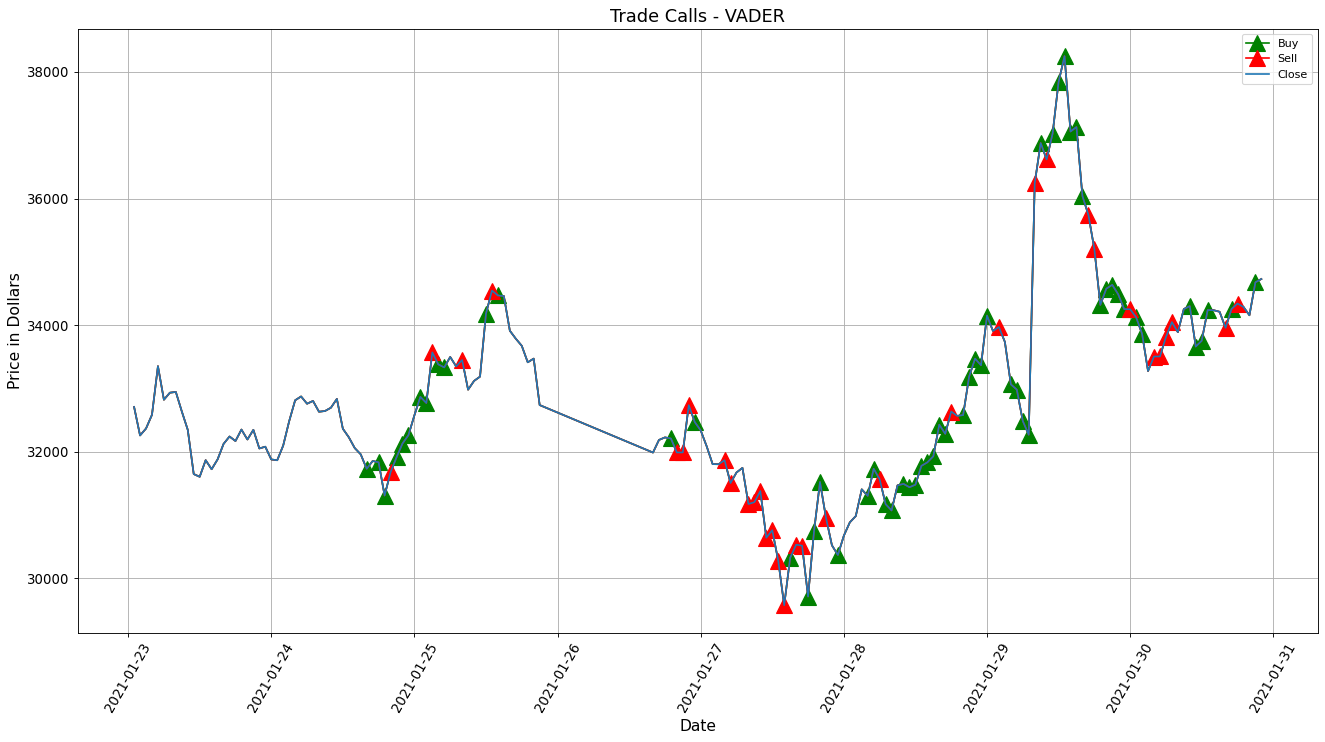

In [47]:
if __name__ == "__main__":
    main()